In [1]:
import pandas as pd

import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
#plt.figure(figzise=(50,10))
sns.set(rc={'figure.figsize':(100,10)})

In [2]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
# task 2

q = """
SELECT
count()
FROM
default.ldn_listings
"""


In [4]:
listings_test = ph.read_clickhouse(query = q, connection = connection_default)

listings_test

count()
0    85207

In [5]:
# task 3


q_task3 = """
select
id
,room_type
,toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price
from
default.ldn_listings
order by id
limit 1000
"""

task3_df = ph.read_clickhouse(query = q_task3, connection = connection_default)
task3_df

id        room_type  price
0     13913     Private room   65.0
1     15400  Entire home/apt  100.0
2     17402  Entire home/apt  300.0
3     17506     Private room  150.0
4     25023  Entire home/apt   65.0
..      ...              ...    ...
995  541081  Entire home/apt  110.0
996  541363  Entire home/apt  110.0
997  542231     Private room   65.0
998  542646  Entire home/apt  100.0
999  542754  Entire home/apt   80.0

[1000 rows x 3 columns]

In [6]:
task3_df.groupby(['room_type']).price.quantile(q=0.75).reset_index()

room_type   price
0  Entire home/apt  160.00
1       Hotel room  157.00
2     Private room   70.00
3      Shared room   69.25

In [7]:
# task 4

q_task4 = """

with t as
(
select
room_type
,toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price
,review_scores_rating
from
default.ldn_listings
where 1=1
and review_scores_rating <> ''
order by id
limit 1000

)

select
room_type
,price
,toFloat32OrNull(review_scores_rating) as review_scores_rating 
from t

"""

task4_df = ph.read_clickhouse(query = q_task4, connection = connection_default)
task4_df




room_type  price  review_scores_rating
0       Private room   65.0                  97.0
1    Entire home/apt  100.0                  96.0
2    Entire home/apt  300.0                  94.0
3    Entire home/apt   65.0                  93.0
4       Private room   29.0                  96.0
..               ...    ...                   ...
995  Entire home/apt  165.0                 100.0
996     Private room   99.0                  93.0
997     Private room   45.0                 100.0
998     Private room   20.0                  88.0
999  Entire home/apt  100.0                  90.0

[1000 rows x 3 columns]

In [8]:
task4_df_agg = task4_df.groupby(['room_type']).agg({'price':'mean','review_scores_rating':'mean'}).reset_index()
task4_df_agg

room_type       price  review_scores_rating
0  Entire home/apt  135.882950             93.568787
1       Hotel room  134.000000             92.500000
2     Private room   54.642437             94.766205
3      Shared room   21.000000             90.000000

In [9]:
# import seaborn as sns

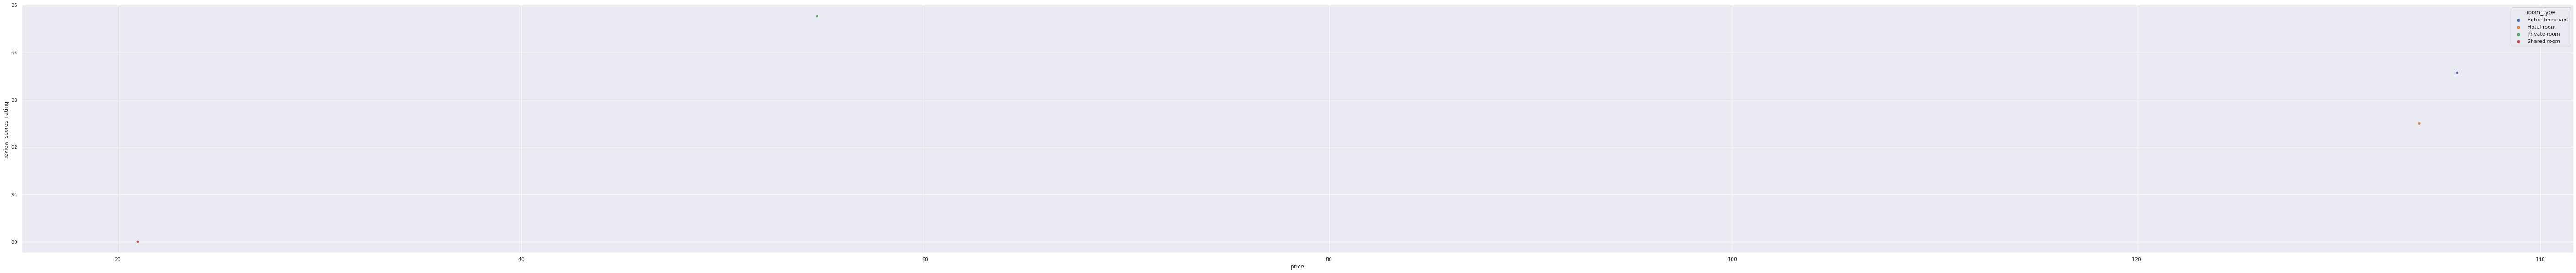

In [10]:
sns.scatterplot(data=task4_df_agg,x='price',y='review_scores_rating',hue='room_type')

In [11]:
# task 5

q_task5 = """

select
distinct host_id
,host_verifications
from
default.ldn_listings
where 1=1
and experiences_offered != 'none'
order by id

"""

task5_df = ph.read_clickhouse(query = q_task5, connection = connection_default)
task5_df







host_id                                 host_verifications
0        54730  ['email', 'phone', 'facebook', 'reviews', 'off...
1        60302  ['email', 'phone', 'reviews', 'jumio', 'govern...
2        67915  ['email', 'phone', 'jumio', 'selfie', 'governm...
3       167107  ['email', 'phone', 'manual_offline', 'jumio', ...
4       103583  ['email', 'phone', 'reviews', 'offline_governm...
...        ...                                                ...
1356  21558962  ['email', 'phone', 'reviews', 'jumio', 'govern...
1357  21257846  ['email', 'phone', 'reviews', 'jumio', 'offlin...
1358  34219613  ['email', 'phone', 'reviews', 'jumio', 'govern...
1359  34299581  ['email', 'phone', 'google', 'reviews', 'jumio...
1360  26917573  ['email', 'phone', 'reviews', 'manual_offline'...

[1361 rows x 2 columns]

In [12]:
task_list_maker = lambda x: x.strip('[]').replace("'","").replace(", "," ").split(' ')

In [13]:
task5_df['host_verifications'] = task5_df['host_verifications'].apply(task_list_maker)

In [14]:
task5_df

host_id                                 host_verifications
0        54730  [email, phone, facebook, reviews, offline_gove...
1        60302      [email, phone, reviews, jumio, government_id]
2        67915  [email, phone, jumio, selfie, government_id, i...
3       167107  [email, phone, manual_offline, jumio, offline_...
4       103583  [email, phone, reviews, offline_government_id,...
...        ...                                                ...
1356  21558962      [email, phone, reviews, jumio, government_id]
1357  21257846  [email, phone, reviews, jumio, offline_governm...
1358  34219613      [email, phone, reviews, jumio, government_id]
1359  34299581  [email, phone, google, reviews, jumio, offline...
1360  26917573  [email, phone, reviews, manual_offline, jumio,...

[1361 rows x 2 columns]

In [15]:
task5_df = task5_df.explode('host_verifications')

task5_df

host_id     host_verifications
0        54730                  email
0        54730                  phone
0        54730               facebook
0        54730                reviews
0        54730  offline_government_id
...        ...                    ...
1360  26917573                  phone
1360  26917573                reviews
1360  26917573         manual_offline
1360  26917573                  jumio
1360  26917573          government_id

[7976 rows x 2 columns]

In [16]:
task5_df.host_verifications.value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

In [17]:
task5_df.host_verifications.value_counts().google

34

In [18]:
# task 6

q_task6 = """

select
neighbourhood_cleansed
,experiences_offered
,count() experiences_count
from
default.ldn_listings
where 1=1
and experiences_offered != 'none'
group by neighbourhood_cleansed, experiences_offered
limit 100

"""

task6_df = ph.read_clickhouse(query = q_task6, connection = connection_default)
task6_df



neighbourhood_cleansed experiences_offered  experiences_count
0                   Harrow              family                  1
1                    Brent              family                 21
2   Kensington and Chelsea              family                 32
3                Islington              family                 44
4                 Haringey              family                 21
..                     ...                 ...                ...
95                  Ealing            business                  6
96                 Hackney            business                 44
97  Hammersmith and Fulham              family                 28
98                 Croydon              family                  3
99                 Enfield              social                  2

[100 rows x 3 columns]

In [19]:
task6_df_pivot = task6_df.pivot_table('experiences_count',index='neighbourhood_cleansed',columns='experiences_offered',aggfunc='sum',fill_value = 0)

In [20]:
task6_df_pivot

experiences_offered     business  family  romantic  social
neighbourhood_cleansed                                    
Barking and Dagenham           1       0         0       2
Barnet                         7       7         3       5
Bexley                         1       0         0       0
Brent                          9      21         5       6
Bromley                        3       2         1       4
Camden                        36      30        19      25
City of London                 7       1         1       0
Croydon                        0       3         0       4
Ealing                         6      13         0       0
Enfield                        0       0         0       2
Greenwich                      9       4         1       5
Hackney                       44      61        25      49
Hammersmith and Fulham        48      28         8      22
Haringey                      12      21         4       0
Harrow                         3       1         0       3
Havering                       0       0         0       1
Hillingdon                     0       1         0       1
Hounslow                       6       8         1       2
Islington                     41      44        20      26
Kensington and Chelsea        37      32        30      13
Kingston upon Thames           3       4         0       1
Lambeth                        0      25        11      41
Lewisham                      11      16         2      10
Merton                         3       4         2       3
Newham                         0       9         0       0
Redbridge                      3       0         0       2
Richmond upon Thames          10       7         2       5
Southwark                     24      21         9      34
Sutton                         3       0         1       0
Tower Hamlets                 58      16        13      46
Waltham Forest                14       4         0      12
Wandsworth                    23       0        13      13
Westminster                    0      37        23      18

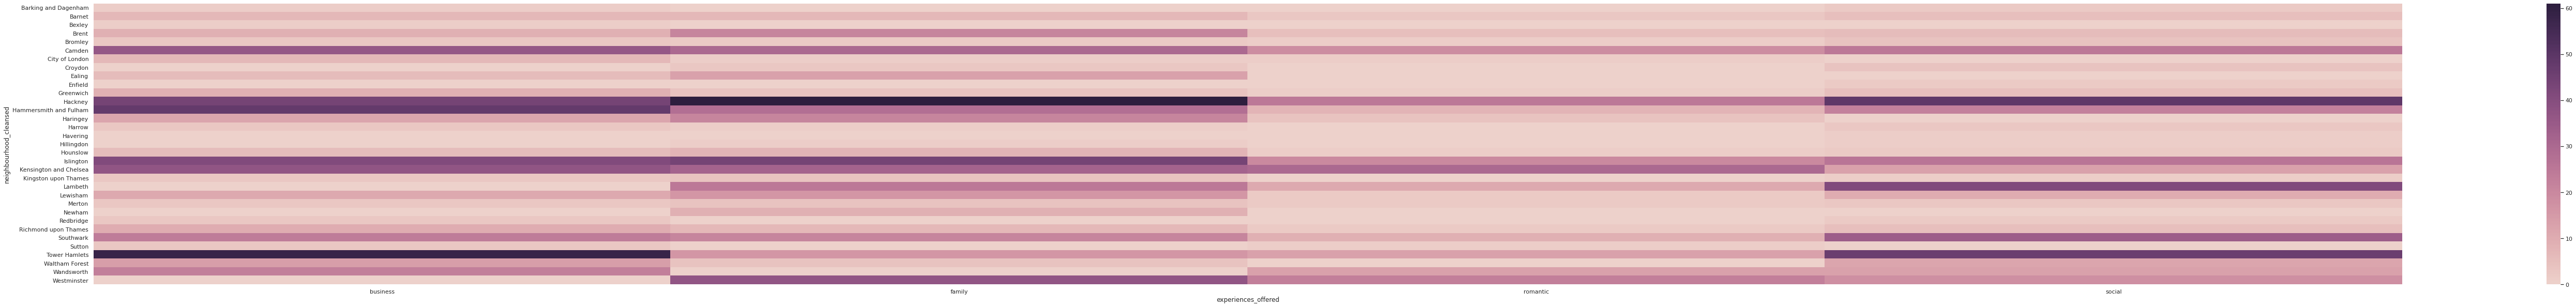

In [21]:
sns.heatmap(task6_df_pivot,cmap=sns.cubehelix_palette(as_cmap=True))

In [22]:
# task 7

q_task7 = """

select
room_type
,toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price
from
default.ldn_listings
where 1=1
and experiences_offered != 'none'


"""

task7_df = ph.read_clickhouse(query = q_task7, connection = connection_default)
task7_df





room_type  price
0        Private room   65.0
1     Entire home/apt  100.0
2        Private room  150.0
3        Private room   45.0
4        Private room   25.0
...               ...    ...
1543  Entire home/apt  100.0
1544  Entire home/apt  125.0
1545  Entire home/apt  185.0
1546  Entire home/apt  110.0
1547     Private room   39.0

[1548 rows x 2 columns]

In [23]:
# sns.set(rc={'figure.figsize':(100,10)})

sns.set(rc={'figure.figsize':(30,10)})


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


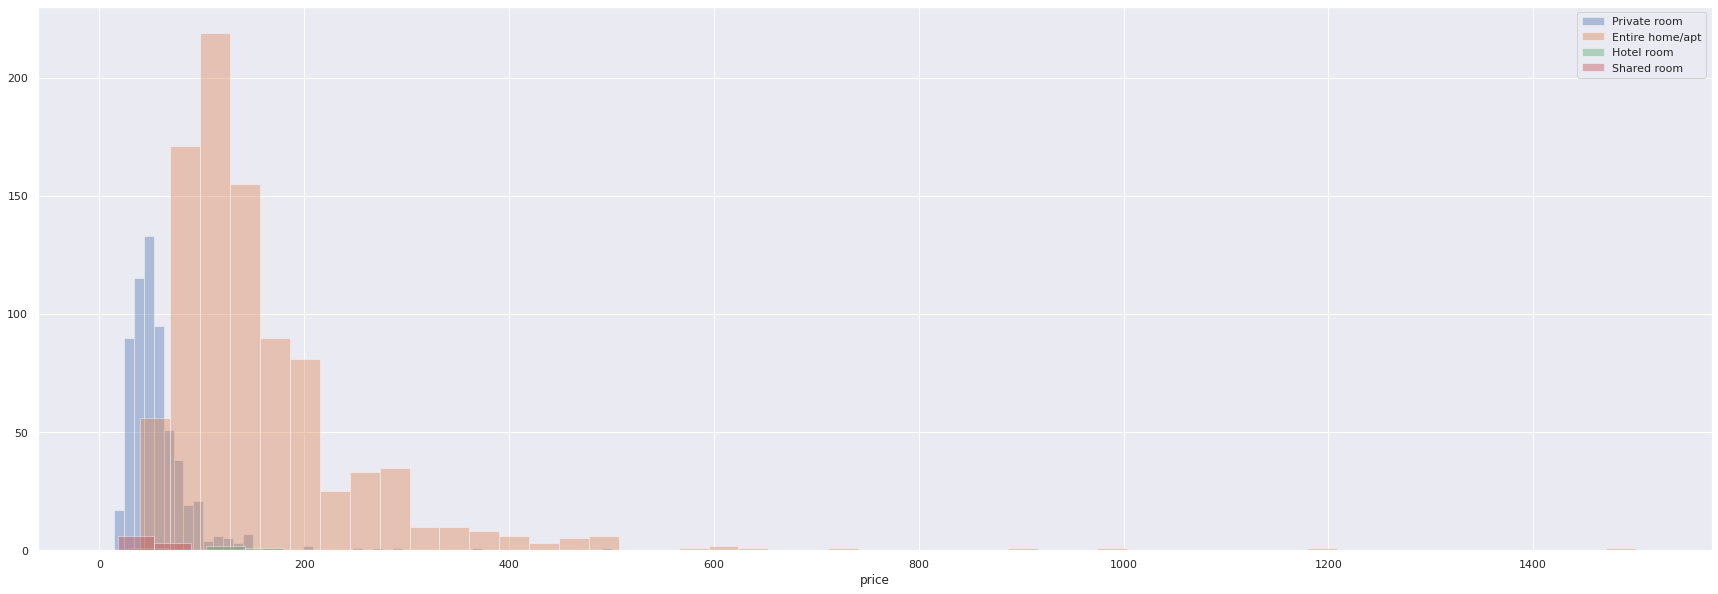

In [24]:
# sns.displot(data=task7_df,x="price",kind="hist",hue="room_type")

sns.distplot(task7_df.query('room_type == "Private room"').price, kde=False, label='Private room')
sns.distplot(task7_df.query('room_type == "Entire home/apt"').price, kde=False, label = 'Entire home/apt')
sns.distplot(task7_df.query('room_type == "Hotel room"').price, kde=False, label = 'Hotel room')
sns.distplot(task7_df.query('room_type == "Shared room"').price, kde=False, label = 'Shared room')

plt.legend()
plt.show()

In [25]:
task7_df_changed = task7_df.copy()

In [26]:
import numpy as np

task7_df_changed['price'] = np.log(task7_df_changed['price'])

In [27]:
task7_df_changed

room_type     price
0        Private room  4.174387
1     Entire home/apt  4.605170
2        Private room  5.010635
3        Private room  3.806663
4        Private room  3.218876
...               ...       ...
1543  Entire home/apt  4.605170
1544  Entire home/apt  4.828314
1545  Entire home/apt  5.220356
1546  Entire home/apt  4.700480
1547     Private room  3.663562

[1548 rows x 2 columns]

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


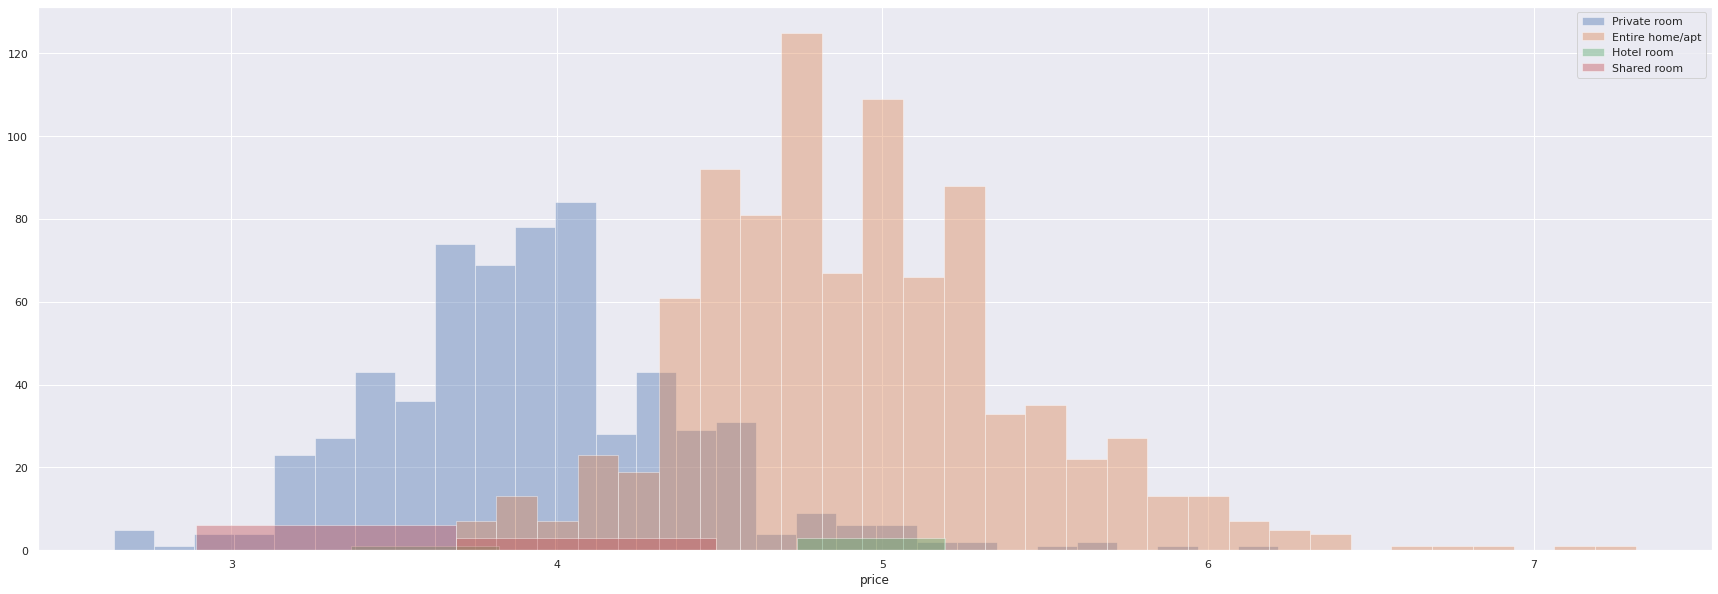

In [28]:
sns.distplot(task7_df_changed.query('room_type == "Private room"').price, kde=False, label='Private room')
sns.distplot(task7_df_changed.query('room_type == "Entire home/apt"').price, kde=False, label = 'Entire home/apt')
sns.distplot(task7_df_changed.query('room_type == "Hotel room"').price, kde=False, label = 'Hotel room')
sns.distplot(task7_df_changed.query('room_type == "Shared room"').price, kde=False, label = 'Shared room')

plt.legend()
plt.show()

In [31]:
# task 8


q_task8 = """

select
room_type
,toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price
,first_review 
from
default.ldn_listings
where 1=1
and first_review > '2010-01-01'
limit 1000


"""

task8_df = ph.read_clickhouse(query = q_task8, connection = connection_default)
task8_df




room_type  price first_review
0       Private room   65.0   2010-08-18
1    Entire home/apt  300.0   2011-03-21
2    Entire home/apt   65.0   2016-03-05
3       Private room   29.0   2010-04-14
4       Private room  100.0   2010-10-16
..               ...    ...          ...
995     Private room   45.0   2012-11-07
996     Private room   51.0   2013-03-18
997  Entire home/apt   79.0   2012-09-17
998  Entire home/apt  110.0   2012-09-24
999     Private room   70.0   2012-11-26

[1000 rows x 3 columns]

In [32]:
task8_cleaner = lambda x: x[:len(x)-6]

In [34]:
task8_df.first_review = task8_df.first_review.apply(task8_cleaner)

In [35]:
task8_df

room_type  price first_review
0       Private room   65.0         2010
1    Entire home/apt  300.0         2011
2    Entire home/apt   65.0         2016
3       Private room   29.0         2010
4       Private room  100.0         2010
..               ...    ...          ...
995     Private room   45.0         2012
996     Private room   51.0         2013
997  Entire home/apt   79.0         2012
998  Entire home/apt  110.0         2012
999     Private room   70.0         2012

[1000 rows x 3 columns]

In [36]:
task8_df_final = task8_df.copy()

In [39]:
task8_df_final = task8_df_final.groupby(['room_type','first_review']).agg({'price':'mean'}).reset_index()

In [40]:
task8_df_final

room_type first_review       price
0   Entire home/apt         2010  103.500000
1   Entire home/apt         2011  128.792450
2   Entire home/apt         2012  135.467255
3   Entire home/apt         2013  137.887634
4   Entire home/apt         2014  154.583328
5   Entire home/apt         2015  159.380951
6   Entire home/apt         2016   99.733330
7   Entire home/apt         2017  111.666664
8   Entire home/apt         2018  125.066666
9   Entire home/apt         2019  301.666656
10  Entire home/apt         2020   50.000000
11       Hotel room         2010   88.000000
12       Hotel room         2017  180.000000
13     Private room         2010   56.428570
14     Private room         2011   52.607143
15     Private room         2012   53.269840
16     Private room         2013   57.036587
17     Private room         2014   56.842106
18     Private room         2015   48.058823
19     Private room         2016   57.307693
20     Private room         2017   51.142857
21     Private room         2018   55.416668
22     Private room         2019   74.000000
23     Private room         2020   39.000000
24      Shared room         2012   22.000000
25      Shared room         2014   20.000000

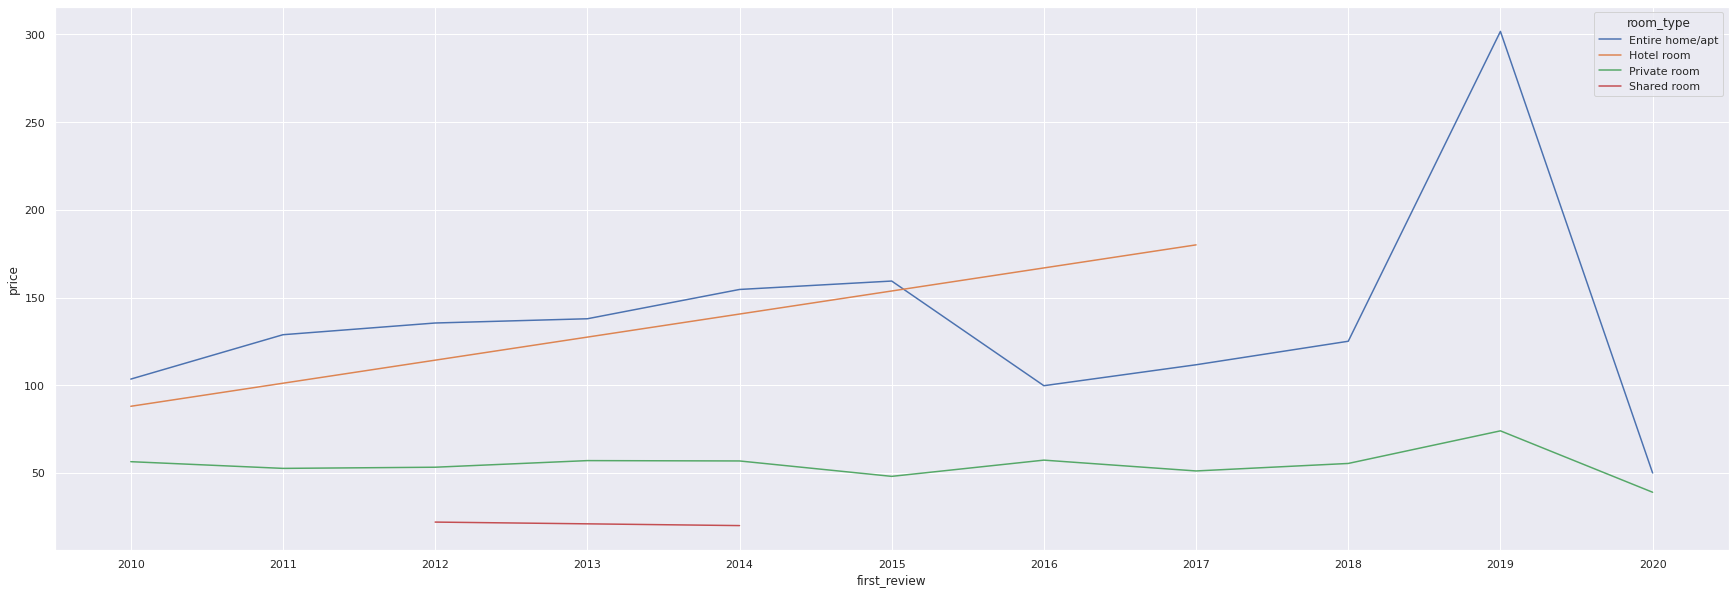

In [41]:
sns.lineplot(data=task8_df_final,y='price',x='first_review',hue='room_type')